In [1]:
import json
import re
import pandas as pd
import numpy as np
import random
import nltk
import codecs
import io
import pickle
import seaborn as sns

from textblob import TextBlob
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

#Extracting features from text, define target y and data X
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics


%matplotlib inline

# First, let's load all of the training data that we want to use. This includes:

- Short movie reviews
- Airline reviews
- Yelp reviews
- Amazon reviews
- Data from this study: https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf, which took tweets and calssified positive/negative based on the emojis.

I realize that the semantics isn't going to be identical to subway tweet replies, but language is language - hopefully we have good enough information to classify positive or negative.

Side thought: why am I classifying language? So I can classify if it's pos/neg, but we probably want to know _how_ pos/neg the tweet is. The model will classify some not-so-negative replies as negative, and we don't want to tell people who aren't impolite to be polite.

How do I do this? After classifying as positive or negative, do I assign it a score? What's the point of classifying if I can just use NLTK SentimentAnalyzer from the get-go?

Maybe after categorizing as pos/neg, we flag tweets for certain words. Then based on the words and the level of positive/negativity, we determine what our response is. Again...we might not need to build a classifier for this, but let's do it for shit's and giggles anyway.

### The challenge:
All this data is formatted differently, so we want to go through each file and preprocess them so that they are the same.

We also want to clean up the tweets probably the most. How do we handle words that are in CAPS, or emphatic uses of repetitive worddddddds, or emoji's?

Let's combine them so they have 3 main columns: source, post-processed tweet, pos or neg


### The steps:
1. Transform dataset
    a. read, remove urls and punctuations, stem the words, created cleaned_tweets and sentiment columns
    b. Shuffle dataset
2. SKLEARN
3. NLTK

### Short movie reviews

In [2]:
# Transform

short_pos = io.open("../data/training_data/short_positive_movie_reviews.txt", "r", encoding="latin-1").read()
short_neg = io.open("../data/training_data/short_negative_movie_reviews.txt", "r", encoding="latin-1").read()

all_reviews = []

stop_words = set(stopwords.words("english"))
ps = PorterStemmer()

## NOTE: BE CAREFUL THAT THE REGEX REMOVING PUNCTUATIONS ISN'T REMOVING TOO MUCH
# Let's also do some stemming to the dataset

for i in short_pos.split('\n'):
    # remove punctuations
    i = re.sub(r'[^\w\s]','',i)
    # tokenize the words in the short reviews first
    words = word_tokenize(i)
    # remove stop words
    filtered_pos = [ps.stem(w) for w in words if not w in stop_words]
    all_reviews.append((' '.join(filtered_pos), "positive"))
    
for i in short_neg.split('\n'):
    # remove punctuations
    i = re.sub(r'[^\w\s]','',i)    
    # tokenize the words in the short reviews first
    words = word_tokenize(i)
    
    # remove stop words
    filtered_neg = [ps.stem(w) for w in words if not w in stop_words]
    all_reviews.append((' '.join(filtered_neg), "negative"))
    
print(len(all_reviews))

smr_df = pd.DataFrame(all_reviews, columns=['cleaned_tweets', 'sentiment'])
# shuffle dataframe
smr_df = smr_df.sample(frac=1).reset_index(drop=True)
smr_df['source'] = 'short_movie_reviews'
print(smr_df.shape)

10662
(10662, 3)


In [3]:
smr_df.sample(10)

,cleaned_tweets,sentiment,source
4068,muckrak job cinemat equival legal indict fairl...,positive,short_movie_reviews
1910,could first major studio product shot video ta...,positive,short_movie_reviews
8145,loathsom movi realli make absolut sens,negative,short_movie_reviews
2009,martyr get royal screw come back,positive,short_movie_reviews
6384,score point dedic goodheart profession,positive,short_movie_reviews
4822,strident ineleg messagemovi postur,negative,short_movie_reviews
3836,hourandahalf inoffens unmemor filler,negative,short_movie_reviews
8582,summer entertain adult see without feel embarr...,positive,short_movie_reviews
6397,supposedli authent account histor event that f...,negative,short_movie_reviews
4315,although lace humor fanci touch film refreshin...,positive,short_movie_reviews


In [38]:
smr_df.sentiment.value_counts()

negative    5331
positive    5331
Name: sentiment, dtype: int64

#### Sklearn

In [48]:
# let's do the damn thang
# create a function, maybe add a parameter to account for max_features

def sklearn_naive_bayes(train, cat, n_features):
    vect = TfidfVectorizer(ngram_range=(1, 2), max_features=n_features)
    X = vect.fit_transform(train)
    y = cat

    #Partitioning the data into test and training set
    SPLIT_PERC = 0.75
    split_size = int(len(y)*SPLIT_PERC)

    X_train = X[:split_size]
    X_test = X[split_size:]
    y_train = y[:split_size]
    y_test = y[split_size:]

    #Training the model
    clf = MultinomialNB()
    clf.fit(X_train, y_train)

    #Evaluating the results
    print("Accuracy on training set:")
    print(clf.score(X_train, y_train))
    print("Accuracy on testing set:")
    print(clf.score(X_test, y_test))
    y_pred = clf.predict(X_test)
    print("Classification Report:")
    print(metrics.classification_report(y_test, y_pred))

In [49]:
sklearn_naive_bayes(smr_df['cleaned_tweets'], smr_df['sentiment'], 1000)

Accuracy on training set:
0.7717608804402201
Accuracy on testing set:
0.7291822955738935
Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.73      0.73      1305
    positive       0.74      0.73      0.73      1361

   micro avg       0.73      0.73      0.73      2666
   macro avg       0.73      0.73      0.73      2666
weighted avg       0.73      0.73      0.73      2666



^^ why *was* this accuracy so bad?? BECAUSE max_features was set to be so high. I think it caused some overfitting.

the first step of appending lines to a list is VERY slow. maybe do the processes separately, i.e., created a column where the tweets are split, and then zip them together with sentiment.

#### NLTK
Note that I'm only using unigrams for NLTK cuz I haven't figured out how to use bigrams with it

In [6]:
def nltk_naive_bayes(df, n_features):

    # split the cleaned_tweets column
    df['split_tweets'] = df.cleaned_tweets.apply(lambda x: x.split())
    all_reviews = zip(df.split_tweets, df.sentiment)

    all_tweets = ' '.join(df['cleaned_tweets']).split()

    freq_tweets = nltk.FreqDist(all_tweets)
    print('The top 50 most common words are:')
    print(freq_tweets.most_common(50))

    word_features = [w[0] for w in freq_tweets.most_common(n_features)]
    # as we can see, there are a lot of stop words in this list. we should consider
    # removing the stop words to get better word features, but for now let's leave them in.
    
    def find_features(document):
        words = set(document)
        features = {}
        for w in word_features:
            features[w] = (w in words)

        return features

    featuresets = [(find_features(rev), category) for (rev, category) in all_reviews]

    training_set = featuresets[:int(len(featuresets)*.75)]
    testing_set = featuresets[int(len(featuresets)*.75):]


    # This is the algorithm calculation:
    # posterior = prior occurences x likelihood / evidence
    # the above gives us the likelihood of something to be positive (or negative). It's not the best algorithm,
    # but it's scalable and easy to use

    classifier = nltk.NaiveBayesClassifier.train(training_set)
    print("Naive Bayes Algo accuracy:", (nltk.classify.accuracy(classifier, testing_set))*100)
    classifier.show_most_informative_features(25)

In [8]:
nltk_naive_bayes(smr_df, 800)

The top 50 most common words are:
[(u'film', 1804), (u'movi', 1544), (u'like', 805), (u'one', 763), (u'make', 611), (u'stori', 536), (u'charact', 483), (u'time', 466), (u'comedi', 392), (u'good', 389), (u'even', 388), (u'much', 386), (u'work', 368), (u'perform', 359), (u'feel', 337), (u'way', 336), (u'get', 310), (u'littl', 302), (u'love', 296), (u'look', 294), (u'funni', 285), (u'director', 274), (u'enough', 267), (u'never', 262), (u'take', 249), (u'may', 245), (u'come', 242), (u'us', 241), (u'seem', 240), (u'thing', 240), (u'bad', 238), (u'best', 237), (u'life', 232), (u'doesnt', 232), (u'see', 231), (u'end', 231), (u'entertain', 231), (u'watch', 226), (u'would', 222), (u'well', 220), (u'plot', 212), (u'there', 211), (u'new', 207), (u'go', 201), (u'interest', 200), (u'someth', 200), (u'could', 199), (u'year', 198), (u'realli', 197), (u'audienc', 196)]
('Naive Bayes Algo accuracy:', 71.23030757689422)
Most Informative Features
                    flat = True           negati : positi 

#### GREAT! OK. Let's make some functions so we can reproduce these steps with the other datasets

It might be worth doing some sort of gridsearch to find the point of diminishing returns for number of features to include in your model

### Airline reviews

In [7]:
# let's take a look at another dataset that we might be able to train with
airlines = pd.read_csv('data/training_data/airline_reviews.csv')
print(airlines.shape)
airlines.head()

(14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [8]:
airlines.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [26]:
# clean tweet with function i found online
def clean_tweet(tweet): 
    ''' 
    Utility function to clean tweet text by removing links, special characters 
    using simple regex statements. 
    '''
    x = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) | (\w+:\/\/\S+)", " ", tweet).split())
    cleaned = re.sub(r'[^\x00-\x7f]',r'', re.sub(r'https:\/\/t.co\/[A-z0-9]*', '', x))
    #take out the hashtags
    without_hashtags = re.sub(r'[^\x00-\x7f]',r'', re.sub(r'\#[A-z0-9]*', '', cleaned))
    # or you can remove it by applying: .decode('utf8').encode('ascii', errors='ignore')
    return without_hashtags

# tokenize and shit
def tokenize_and_stem(row):
    
    # remove punctuations
    i = re.sub(r'[^\w\s]','',row)    
    # tokenize the words in the short reviews first
    words = word_tokenize(i)
    # remove stop words
    filtered = [ps.stem(w) for w in words if not w in stop_words]
    return ' '.join(filtered)



In [ ]:

airlines['cleaned'] = airlines['text'].apply(lambda x: clean_tweet(x))
# remove neutral
alrlines = airlines.loc[airlines.airline_sentiment != 'neutral']
airlines['training_text'] = airlines['cleaned'].apply(lambda x: tokenize_and_stem(x))
# make training dataset to append to the master dataset
# columns = cleaned_tweets, sentiment, source
airlines_df = airlines[['training_text', 'airline_sentiment']]
airlines_df.columns = ['cleaned_tweets', 'sentiment']
airlines_df['source'] = 'airline_reviews'
airlines_df.sample(10)

#### Sklearn

In [12]:
sklearn_naive_bayes(airlines_df['cleaned_tweets'], airlines_df['sentiment'], 1000)

Accuracy on training set:
0.75218579235
Accuracy on testing set:
0.785245901639
Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.96      0.87      2627
     neutral       0.56      0.23      0.32       577
    positive       0.81      0.46      0.59       456

   micro avg       0.79      0.79      0.79      3660
   macro avg       0.73      0.55      0.60      3660
weighted avg       0.76      0.79      0.75      3660



# NOTE: WHY IS TRAINING SET ACCURACY LESS THAN TEST SET ACCURACY??

#### NLTK

In [13]:
nltk_naive_bayes(airlines_df, 800)

/Users/andrewrubino/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


The top 50 most common words are:
[(u'I', 5077), (u'flight', 4775), (u'thank', 1682), (u'get', 1615), (u'hour', 1133), (u'cancel', 1048), (u'help', 1022), (u'servic', 990), (u'delay', 969), (u'time', 960), (u'custom', 933), (u'call', 768), (u'bag', 757), (u'wait', 744), (u'plane', 718), (u'Im', 718), (u'fli', 686), (u'need', 684), (u'hold', 680), (u'2', 643), (u'amp', 638), (u'go', 616), (u'tri', 582), (u'cant', 580), (u'one', 577), (u'still', 572), (u'pleas', 564), (u'would', 548), (u'airlin', 545), (u'day', 542), (u'gate', 539), (u'back', 526), (u'us', 521), (u'flightl', 520), (u'seat', 513), (u'dont', 498), (u'book', 497), (u'make', 479), (u'got', 478), (u'chang', 461), (u'phone', 450), (u'like', 448), (u'check', 434), (u'late', 423), (u'today', 422), (u'guy', 421), (u'agent', 415), (u'work', 407), (u'miss', 404), (u'you', 395)]
('Naive Bayes Algo accuracy:', 79.04371584699453)
Most Informative Features
                    rock = True           positi : negati =     27.9 : 1.0
     

### Yelp Reviews

In [10]:
yelp = pd.read_csv('data/training_data/yelp_labelled.txt', sep="\t", header=None)
yelp.columns = ['review', 'category']
print(yelp.shape)

# clean, tokenize, etc

yelp['cleaned'] = yelp['review'].apply(lambda x: clean_tweet(x))
yelp['cleaned_tweets'] = yelp['cleaned'].apply(lambda x: tokenize_and_stem(x))
yelp['sentiment'] = np.where(yelp.category == 1, 'positive', 'negative')
yelp['source'] = 'yelp'
yelp_df = yelp[['cleaned_tweets', 'sentiment', 'source']]
yelp_df.sample(10)

(1000, 2)


,cleaned_tweets,sentiment,source
752,level 5 spici perfect spice didnt overwhelm soup,positive,yelp
719,We order old classic new dish go time sore dis...,negative,yelp
879,now burger arent good pizza use amaz doughi fl...,negative,yelp
643,mayb werent cold would somewhat edibl,negative,yelp
742,Im sure long stood long enough begin feel awkw...,negative,yelp
780,I pretti satifi experi,positive,yelp
158,place good,positive,yelp
348,5 star brick oven bread app,positive,yelp
918,they brought fresh batch fri I think yay somet...,negative,yelp
754,main thing I didnt enjoy crowd older crowd aro...,negative,yelp


In [9]:
yelp_df.sentiment.value_counts()

negative    500
positive    500
Name: sentiment, dtype: int64

#### Sklearn

In [16]:
sklearn_naive_bayes(yelp_df['cleaned_tweets'], yelp_df['sentiment'], 800)

Accuracy on training set:
0.92
Accuracy on testing set:
0.704
Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.64      0.75       173
    positive       0.51      0.84      0.64        77

   micro avg       0.70      0.70      0.70       250
   macro avg       0.71      0.74      0.69       250
weighted avg       0.78      0.70      0.72       250



#### NLTK

In [17]:
nltk_naive_bayes(yelp_df, 800)

The top 50 most common words are:
[(u'I', 295), (u'the', 179), (u'food', 125), (u'place', 112), (u'good', 95), (u'servic', 84), (u'great', 70), (u'back', 61), (u'go', 58), (u'time', 55), (u'like', 51), (u'thi', 47), (u'realli', 36), (u'We', 34), (u'love', 33), (u'disappoint', 30), (u'best', 30), (u'wait', 29), (u'ever', 28), (u'would', 28), (u'order', 28), (u'restaur', 28), (u'get', 28), (u'It', 28), (u'dont', 28), (u'one', 27), (u'also', 27), (u'never', 26), (u'friendli', 26), (u'eat', 26), (u'nice', 25), (u'delici', 24), (u'amaz', 23), (u'tast', 22), (u'even', 21), (u'My', 21), (u'vega', 21), (u'price', 21), (u'come', 21), (u'Im', 21), (u'came', 20), (u'ive', 20), (u'experi', 20), (u'minut', 19), (u'wont', 19), (u'pretti', 19), (u'us', 19), (u'staff', 19), (u'recommend', 18), (u'pizza', 18)]


/Users/andrewrubino/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


('Naive Bayes Algo accuracy:', 74.4)
Most Informative Features
                    love = True           positi : negati =     13.2 : 1.0
                    dont = True           negati : positi =      9.6 : 1.0
                    nice = True           positi : negati =      9.5 : 1.0
                    amaz = True           positi : negati =      9.0 : 1.0
                   worst = True           negati : positi =      8.2 : 1.0
                   manag = True           negati : positi =      7.3 : 1.0
                   anoth = True           negati : positi =      6.5 : 1.0
                    menu = True           positi : negati =      6.4 : 1.0
                friendli = True           positi : negati =      6.3 : 1.0
                   never = True           negati : positi =      5.6 : 1.0
                     got = True           negati : positi =      5.4 : 1.0
                    wait = True           negati : positi =      5.4 : 1.0
                   think = True      

Hmm I'm suspicious about some of the words that are showing up in the most informative features list

### Amazon

In [16]:
amazon = pd.read_csv('data/training_data/amazon_cells_labelled.txt', 
                   sep="\t", header=None)
amazon.columns = ['review', 'category']
amazon['sentiment'] = np.where(amazon.category == 1, 'positive', 'negative')
print(amazon.shape)

# clean, tokenize, etc
amazon['cleaned'] = amazon['review'].apply(lambda x: clean_tweet(x))
amazon['cleaned_tweets'] = amazon['cleaned'].apply(lambda x: tokenize_and_stem(x))
amazon['source'] = 'amazon'
amazon_df = amazon[['cleaned_tweets', 'sentiment', 'source']]
amazon_df.sample(10).values

(1000, 3)


array([[u'disappoint accessori good manufactur', 'negative', 'amazon'],
       [u'the ship time also quick', 'positive', 'amazon'],
       [u'razr batteri good buy', 'positive', 'amazon'],
       [ u'thi phone fast send kind messag web brows significantli faster previou phone use',
        'positive', 'amazon'],
       [u'would advis purchas item never work well', 'negative', 'amazon'],
       [u'none new one ever quit work properli', 'negative', 'amazon'],
       ['Oh I forgot also mention weird color effect phone', 'negative',
        'amazon'],
       [u'phone hold charg like new', 'positive', 'amazon'],
       [u'So anyon near hear part convers', 'negative', 'amazon'],
       [u'I realli recommend facepl sinc look nice eleg cool', 'positive',
        'amazon']], dtype=object)

### Sklearn

In [19]:
sklearn_naive_bayes(amazon_df['cleaned_tweets'], amazon_df['sentiment'], 500)

Accuracy on training set:
0.913333333333
Accuracy on testing set:
0.792
Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.79      0.80       135
    positive       0.76      0.80      0.78       115

   micro avg       0.79      0.79      0.79       250
   macro avg       0.79      0.79      0.79       250
weighted avg       0.79      0.79      0.79       250



### NLTK

In [20]:
nltk_naive_bayes(amazon_df, 500)

The top 50 most common words are:
[(u'I', 306), (u'phone', 173), (u'work', 112), (u'the', 99), (u'great', 97), (u'good', 75), (u'use', 71), (u'It', 62), (u'product', 56), (u'headset', 55), (u'thi', 54), (u'qualiti', 49), (u'batteri', 47), (u'sound', 45), (u'one', 41), (u'ear', 41), (u'well', 38), (u'case', 35), (u'would', 34), (u'price', 33), (u'time', 32), (u'get', 32), (u'like', 32), (u'dont', 31), (u'excel', 29), (u'ive', 28), (u'recommend', 27), (u'realli', 26), (u'look', 25), (u'make', 25), (u'comfort', 25), (u'call', 24), (u'not', 24), (u'problem', 24), (u'fit', 23), (u'best', 23), (u'servic', 23), (u'love', 23), (u'nice', 23), (u'buy', 23), (u'charger', 22), (u'veri', 22), (u'also', 22), (u'charg', 22), (u'disappoint', 21), (u'purchas', 21), (u'new', 20), (u'it', 20), (u'item', 20), (u'2', 20)]


/Users/andrewrubino/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


('Naive Bayes Algo accuracy:', 76.8)
Most Informative Features
                   great = True           positi : negati =     21.5 : 1.0
                   excel = True           positi : negati =     13.0 : 1.0
                     not = True           negati : positi =     10.2 : 1.0
                   price = True           positi : negati =     10.1 : 1.0
                    best = True           positi : negati =      9.8 : 1.0
                   could = True           negati : positi =      8.1 : 1.0
                      If = True           negati : positi =      6.7 : 1.0
                    piec = True           negati : positi =      6.0 : 1.0
                  custom = True           negati : positi =      5.3 : 1.0
                    good = True           positi : negati =      4.9 : 1.0
                  highli = True           positi : negati =      4.7 : 1.0
                  button = True           negati : positi =      4.6 : 1.0
                    turn = True      

### Stanford dataset

- 0: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- 1: the id of the tweet (2087)
- 2: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- 3: the query (lyx). If there is no query, then this value is NO_QUERY.
- 4: the user that tweeted (robotickilldozr)
- 5: the text of the tweet (Lyx is cool)

In [2]:
# and then this random training set from airlines
stanford = pd.read_csv('../data/training_data/stanford_training_labelled.csv', header=None)
stanford.columns = ['polarity', 'tweet_id', 'date', 'query', 'user', 'tweet']
print(stanford.shape)

# clean, tokenize, etc
stanford['cleaned'] = stanford['tweet'].apply(lambda x: clean_tweet(x))
stanford['cleaned_tweets'] = stanford['cleaned'].apply(lambda x: tokenize_and_stem(x))
stanford['source'] = 'stanford'
stanford['sentiment'] = np.where(stanford.polarity == 0, 'negative', 
                                 np.where(stanford.polarity == 2, 'neutral', 'positive'))
stanford_df = stanford[['cleaned_tweets', 'sentiment', 'source']]
stanford_df = stanford_df.sample(frac=1).reset_index(drop=True)
stanford_df.sample(10)

UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 80-81: invalid continuation byte

#### Sklearn

In [23]:
sklearn_naive_bayes(stanford_df['cleaned_tweets'], stanford_df['sentiment'], 3000)

Accuracy on training set:
0.7570125
Accuracy on testing set:
0.7561575
Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.76      0.76    199796
    positive       0.76      0.75      0.75    200204

   micro avg       0.76      0.76      0.76    400000
   macro avg       0.76      0.76      0.76    400000
weighted avg       0.76      0.76      0.76    400000



#### NLTK

In [24]:
nltk_naive_bayes(stanford_df, 500)

The top 50 most common words are:
[(u'I', 499424), (u'go', 132897), (u'Im', 110369), (u'get', 109964), (u'day', 101859), (u'good', 90558), (u'work', 85189), (u'like', 82960), (u'love', 81079), (u'got', 70039), (u'dont', 67305), (u'today', 66107), (u'im', 65732), (u'time', 64341), (u'cant', 62889), (u'thank', 57944), (u'want', 57048), (u'back', 56404), (u'miss', 56298), (u'one', 55907), (u'lol', 55385), (u'know', 54053), (u'see', 50788), (u'feel', 50654), (u'think', 50626), (u'realli', 49590), (u'u', 47544), (u'well', 44606), (u'hope', 43741), (u'night', 43218), (u'watch', 43122), (u'need', 42898), (u'still', 42852), (u'make', 42551), (u'new', 42477), (u'na', 41024), (u'that', 40986), (u'amp', 40718), (u'home', 39488), (u'look', 39094), (u'come', 38619), (u'2', 37663), (u'much', 36539), (u'last', 35755), (u'twitter', 34318), (u'morn', 34261), (u'tomorrow', 33346), (u'wish', 33231), (u'great', 32982), (u'wait', 31986)]
('Naive Bayes Algo accuracy:', 72.50325)
Most Informative Features
  

### Append the all together!

Well, let's maybe append part of it together. I don't think we're gonna need all of the stanford dataset, maybe 1/2 of it. The models seem to do pretty good without a ton of data.

1. smr_df
2. airlines_df
3. yelp_df
5. amazon_df
6. stanford_df (50%)

In [19]:
master = (smr_df.append(airlines_df)
          .append(yelp_df)
          .append(amazon_df)
          .append(stanford_df.iloc[:int(len(stanford_df)*.5)])
          .reset_index(drop=True))

print(master.shape)
print(master.source.value_counts())
# shuffle dataset
master = master.sample(frac=1).reset_index(drop=True)
master.head(10)

(827302, 3)
stanford               800000
airline_reviews         14640
short_movie_reviews     10662
yelp                     1000
amazon                   1000
Name: source, dtype: int64


,cleaned_tweets,sentiment,source
0,supercalafragilelisticexpialadoshu wow guess i...,positive,stanford
1,went church hour ago,positive,stanford
2,dnt point often end video crazi guy clapn n da...,negative,stanford
3,stomach realli friendli moment uhhhhh,negative,stanford
4,quotnutella banana bread well that right blasp...,positive,stanford
5,tri run away wind alway say quothel haunt ever...,positive,stanford
6,just one day race england wwwnsrnl,positive,stanford
7,leav cal 2 amp half month let see home goe,negative,stanford
8,start get pictur either compani logo dont face...,positive,stanford
9,I need jqueri base nav menu anyon one _li arou...,positive,stanford


In [20]:
# let's remove the neutral stuff for now
master = master.loc[master.sentiment != 'neutral'].reset_index(drop=True).copy()
master.sentiment.value_counts()

negative    414862
positive    409341
Name: sentiment, dtype: int64

In [21]:
# quickly save this to file
master.to_csv('data/training_data/master_training_data_june22.csv', index=False)

# Wikipedia sentences

In [12]:
# wiki = pd.read_csv('../data/wikisent2.txt', header=None)
# # data.columns = ["a", "b", "c", "etc."]
# print(wiki.shape)
# # wiki.head()

lines = []

with open('../data/wikisent2.txt', encoding='utf-8') as f:
    for line in f:
        lines.append(line[:-2])

lines[:10]

['0.000123, which corresponds to a distance of 705 Mly, or 216 Mpc',
 '000webhost is a free web hosting service, operated by Hostinger',
 '0010x0010 is a Dutch-born audiovisual artist, currently living in Los Angeles',
 '0-0-1-3 is an alcohol abuse prevention program developed in 2004 at Francis E. Warren Air Force Base based on research by the National Institute on Alcohol Abuse and Alcoholism regarding binge drinking in college students',
 '0.01 is the debut studio album of H3llb3nt, released on February 20, 1996 by Fifth Colvmn Records',
 '001 of 3 February 1997, which was signed between the Government of the Republic of Rwanda, and FAPADER',
 '003230 is a South Korean food manufacturer',
 '0.04%Gas molecules in soil are in continuous thermal motion according to the kinetic theory of gasses, there is also collision between molecules - a random walk',
 '0.04% of the votes were invalid',
 '005.1999.06 is the fifth studio album by the South Korean singer and actress Uhm Jung-hwa']

In [28]:
wiki_df = pd.DataFrame({'sentence':lines,
                         'sentiment':'neutral',
                         'source':'wikipedia'})

print(wiki_df.shape)
wiki_df.head()

(7871825, 3)


,sentence,sentiment,source
0,"0.000123, which corresponds to a distance of 7...",neutral,wikipedia
1,"000webhost is a free web hosting service, oper...",neutral,wikipedia
2,"0010x0010 is a Dutch-born audiovisual artist, ...",neutral,wikipedia
3,0-0-1-3 is an alcohol abuse prevention program...,neutral,wikipedia
4,"0.01 is the debut studio album of H3llb3nt, re...",neutral,wikipedia


In [39]:
np.random.seed(24)

wiki_sample = wiki_df.sample(400000)

wiki_sample['cleaned'] = wiki_sample['sentence'].apply(lambda x: clean_tweet(x))
wiki_sample['cleaned_tweets'] = wiki_sample['cleaned'].apply(lambda x: tokenize_and_stem(x))

In [41]:
wiki_sample.sample(10)

,sentence,sentiment,source,cleaned,cleaned_tweets
6106192,"The group, between them, own over 700 brands a...",neutral,wikipedia,The group between them own over 700 brands and...,the group 700 brand 4200 pub
4864979,Scheduled in Smart Araneta Coliseum on Februar...,neutral,wikipedia,Scheduled in Smart Araneta Coliseum on Februar...,schedul smart araneta coliseum februari 5 2017...
3416916,It was first published in Four Color Comics #3...,neutral,wikipedia,It was first published in Four Color Comics M...,It first publish four color comic march 1952 s...
6112173,The group sophisticatedly utilizes social medi...,neutral,wikipedia,The group sophisticatedly utilizes social medi...,the group sophisticatedli util social media to...
2536301,"In 2012, he ventured into acting, appearing in...",neutral,wikipedia,In 2012 he ventured into acting appearing in t...,In 2012 ventur act appear film thunderstruck
1346915,"Edward Kellogg Baird (July 13, 1876 - 1951), w...",neutral,wikipedia,Edward Kellogg Baird (July 13 1876 1951) was a...,edward kellogg baird juli 13 1876 1951 attorne...
2836388,"It began in the mid-nineteenth century, with t...",neutral,wikipedia,It began in the mid-nineteenth century with th...,It began midnineteenth centuri construct first...
3747098,Koranganatha Temple is a Hindu temple situated...,neutral,wikipedia,Koranganatha Temple is a Hindu temple situated...,koranganatha templ hindu templ situat town sri...
4087359,MISC-MIFA are the previous champion and curren...,neutral,wikipedia,MISC-MIFA are the previous champion and curren...,miscmifa previou champion current play second ...
5024339,"She was a correspondent with Henry James, and ...",neutral,wikipedia,She was a correspondent with Henry James and w...,she correspond henri jame work pierr villey


In [20]:
master.sentiment.value_counts()

negative    414862
positive    409341
Name: sentiment, dtype: int64

In [44]:
master2 = (master.append(wiki_sample[['cleaned_tweets', 'sentiment', 'source']]
          .reset_index(drop=True)))

master2.sentiment.value_counts()

negative    414862
positive    409341
neutral     400000
Name: sentiment, dtype: int64

In [45]:
master2.sample(10)

,cleaned_tweets,sentiment,source
169415,httpbitly16fp4t um could bee hotter nahh,positive,stanford
370031,It conceiv follow perri divorc english actor c...,neutral,wikipedia
444754,isplay ha die sorri,negative,stanford
711180,Im hope littl less volatil tomorrow I want tak...,negative,stanford
264566,john hooker serv congreg deacon also accept be...,neutral,wikipedia
308519,watchin madonna truth dare girl banana go tour,positive,stanford
206506,Oh sorri read andr,negative,stanford
134960,As 2010 censu popul 136555,neutral,wikipedia
272127,long intergen nonprotein code rna 598 protein ...,neutral,wikipedia
605839,sighteth Im love even will pay extra,negative,stanford


In [ ]:
# remove the null values and write to csv

master2.to_csv('../data/master2.csv', index=False)

### Let's really do the damn thang

#### Sklearn

In [19]:
master2 = pd.read_csv('../data/training_data/master2.csv')
master2 = master2[master2.cleaned_tweets.notnull()]

print(master.shape)
master.head()

(824203, 3)


,cleaned_tweets,sentiment,source
0,supercalafragilelisticexpialadoshu wow guess i...,positive,stanford
1,went church hour ago,positive,stanford
2,dnt point often end video crazi guy clapn n da...,negative,stanford
3,stomach realli friendli moment uhhhhh,negative,stanford
4,quotnutella banana bread well that right blasp...,positive,stanford


In [ ]:
sklearn_naive_bayes(master['cleaned_tweets'], master['sentiment'], 3000)

In [23]:
# sklearn_naive_bayes(df['cleaned_tweets'], df['sentiment'], 500)

vect = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X = vect.fit_transform(master['cleaned_tweets'])
y = master['sentiment']

#Partitioning the data into test and training set
SPLIT_PERC = 0.75
split_size = int(len(y)*SPLIT_PERC)

X_train = X[:split_size]
X_test = X[split_size:]
y_train = y[:split_size]
y_test = y[split_size:]

#Training the model
clf = MultinomialNB()
clf.fit(X_train, y_train)

#Evaluating the results
print("Accuracy on training set:")
print(clf.score(X_train, y_train))
print("Accuracy on testing set:")
print(clf.score(X_test, y_test))
y_pred = clf.predict(X_test)
print("Classification Report:")
print(metrics.classification_report(y_test, y_pred))


Accuracy on training set:
0.762495308597
Accuracy on testing set:
0.758977146435
Classification Report:
              precision    recall  f1-score   support

    negative       0.76      0.77      0.76    103642
    positive       0.76      0.75      0.76    102409

   micro avg       0.76      0.76      0.76    206051
   macro avg       0.76      0.76      0.76    206051
weighted avg       0.76      0.76      0.76    206051



In [24]:
# this code was written by a sklearn dev to show most_important_features for sklearn,
# similar to how NLTK does.

def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for class_label in clf.classes_:
        top10 = np.argsort(clf.coef_)[-10:]
    print("%s: %s" % (class_label,
          " ".join(feature_names[j] for j in top10)))

# print_top10(vect, clf, y_train)

In [25]:
# I don't really know how this works but the results seem interesting since we can see bigram importance

def show_most_informative_features(vectorizer, clf, n=50):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print "\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2)

show_most_informative_features(vect, clf)

	-13.5081	farrah fawcett 		-4.6453	thank          
	-13.5081	fawcett        		-4.8179	love           
	-13.5081	lost pleas     		-4.8784	good           
	-12.8633	happi father   		-4.9835	im             
	-12.8504	hate sick      		-5.1075	go             
	-12.6899	not happi      		-5.1663	day            
	-12.5996	tummi ach      		-5.3182	get            
	-12.4918	realli hurt    		-5.3551	like           
	-12.4655	im lone        		-5.3686	lol            
	-12.4447	not feel       		-5.4892	time           
	-12.4255	flight cancel  		-5.5729	got            
	-12.2953	my poor        		-5.5759	watch          
	-12.2840	much pain      		-5.5968	great          
	-12.2752	sad cant       		-5.6145	today          
	-12.2515	so sad         		-5.6240	see            
	-12.2492	pass away      		-5.6281	new            
	-12.2374	stomach hurt   		-5.6514	one            
	-12.2345	cancel flight  		-5.6659	know           
	-12.2234	sad time       		-5.6989	work           
	-12.1996	sad face       		-5.7

### let's mess around with CV and hyper parameter tuning

My PML_3 notes in week 8 of NYCDS go over how to do this for classification models

In [26]:
import sklearn.model_selection as ms

random_divide = ms.KFold(n_splits=5)
scores = ms.cross_val_score(estimator=clf,
                            X=vect.fit_transform(master['cleaned_tweets']),
                            y=master['sentiment'],
                            cv=random_divide)
scores

array([ 0.75973817,  0.75785757,  0.75938025,  0.7601917 ,  0.75983378])

### You did CV, so now what? Stay tuned tomorrow on the next episode of I have no fucking idea what I'm doing.

Purpose of CV: https://stats.stackexchange.com/questions/52274/how-to-choose-a-predictive-model-after-k-fold-cross-validation


### Save this file to a pickle file since jupyter keeps crashing (modify code below)

In [27]:
save_classifier = open("master_naive_bayes_june22.pickle", "wb")
pickle.dump(clf, save_classifier)
save_classifier.close()

# # lets open the pickle file now
# classifier_f = open("naive_bayes.pickle", "rb")
# classifier = pickle.load(classifier_f)
# classifier_f.close()

# # let's see how it does this time 

# word_features = [w[0] for w in all_words.most_common(3000)]

# featuresets = [(find_features(rev), category) for (rev, category) in documents]

# training_set = featuresets[:1900]
# testing_set = featuresets[1900:]

# print("Naive Bayes Algo accuracy:", (nltk.classify.accuracy(classifier, testing_set))*100)
# classifier.show_most_informative_features(15)



### NLTK Sentiment Analyzer documentation

https://www.nltk.org/howto/sentiment.html

What I think I want to do is have my Naive Bayes model classify tweets as pos/neg. Then, if it's classified as negative, apply from nltk.sentiment.vader import SentimentIntensityAnalyzer so the tweet so that we can measure HOW negative it is

(in the future, maybe we can use a classification model to predict more than two categories - sentiment based on severity of language)


### About the scoring

- The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

- It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

- positive sentiment: compound score >= 0.05
- neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
- negative sentiment: compound score <= -0.05
- The pos, neu, and neg scores are ratios for proportions of text that fall in each category (so these should all add up to be 1... or close to it with float operation). These are the most useful metrics if you want multidimensional measures of sentiment for a given sentence.

In [30]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

sid.polarity_scores(master.cleaned_tweets[3])

{'compound': -0.1531, 'neg': 0.211, 'neu': 0.789, 'pos': 0.0}

In [38]:
# create  columns that contain compound, neg, neu, and pos kv's in the master dataframe
# then, let's plot a histogram to see the distrubution of scores across each
# negative and positive sentment that our naive bayes model has predicted.

master['compound_score'] = master.cleaned_tweets.apply(lambda x: sid.polarity_scores(x)['compound'])
master['neg_score'] = master.cleaned_tweets.apply(lambda x: sid.polarity_scores(x)['neg'])
master['neu_score'] = master.cleaned_tweets.apply(lambda x: sid.polarity_scores(x)['neu'])
master['pos_score'] = master.cleaned_tweets.apply(lambda x: sid.polarity_scores(x)['pos'])

master.sample(10)

,cleaned_tweets,sentiment,source,compound_score,neg_score,neu_score,pos_score
125028,_hisself get 100 follow day use wwwtweeterfoll...,positive,stanford,0.4404,0.089,0.701,0.210
35005,I got today pour,negative,stanford,0.0000,0.000,1.000,0.000
175115,cant wait 4 day till,positive,stanford,0.0000,0.000,1.000,0.000
562727,Ha ive never notic thank fill,positive,stanford,0.0747,0.248,0.470,0.282
632885,good morn,positive,stanford,0.4404,0.000,0.256,0.744
538069,I dont like bingcom It doesnt know I exist,negative,stanford,-0.2755,0.260,0.740,0.000
152849,hill final LC get sens go back ur 60000episod ...,negative,stanford,0.0000,0.000,1.000,0.000
635012,My class start next monday I dont want go scho...,negative,stanford,-0.4628,0.201,0.799,0.000
555223,wait bu homeand walk 15 min bu station get hom...,negative,stanford,0.0000,0.000,1.000,0.000
551958,got home gfx tablet arriv cool natwest card re...,positive,stanford,0.8689,0.000,0.570,0.430


# Seaborn

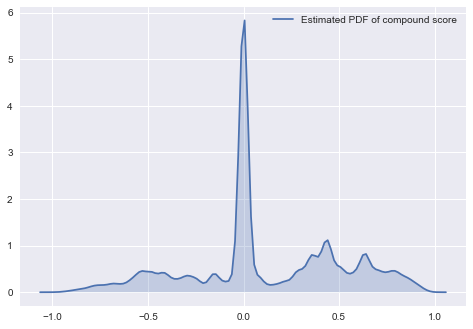

In [45]:
# let's mess around with seaborn, because why not heck not

# first take a distribution of each score
sns.kdeplot(master['compound_score'], shade=True, label='Estimated PDF of compound score')

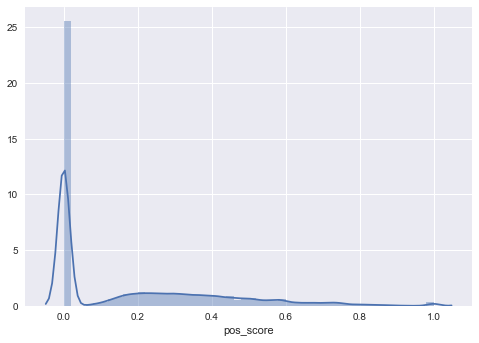

In [51]:
# pretty cool. most compound scores are around 0 which makes sense. what is the yaxis?
sns.distplot(master['pos_score'])

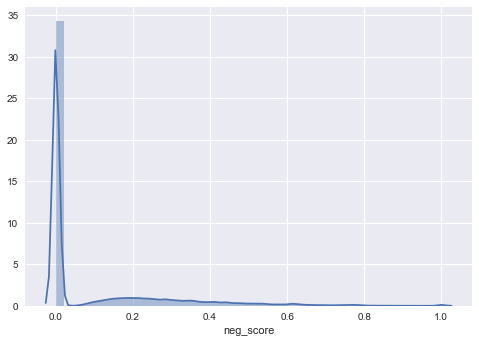

In [52]:
sns.distplot(master['neg_score'])

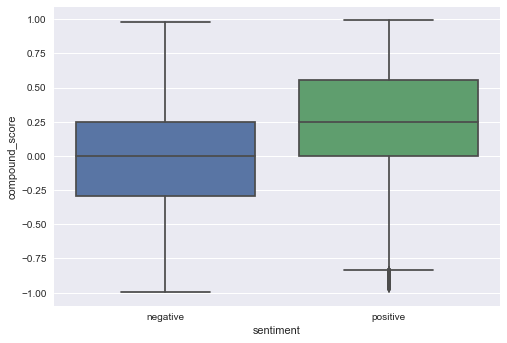

In [53]:
sns.boxplot(x='sentiment', y='compound_score', data=master)

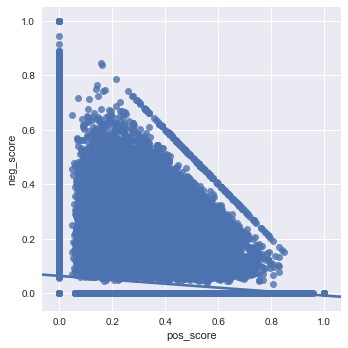

In [58]:
sns.lmplot('pos_score', 'neg_score', master.loc[master.sentiment=='positive'])

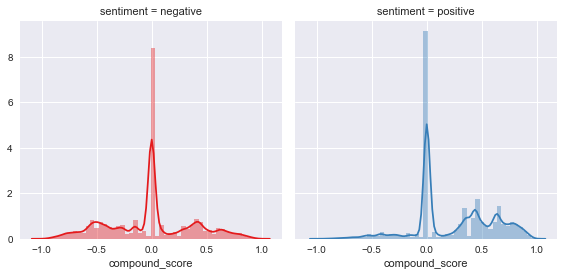

In [60]:
sent_grid = sns.FacetGrid(master, col='sentiment', hue='sentiment', palette="Set1", size=4)
sent_grid.map(sns.distplot, "compound_score")

It seems that the VADER compound scores are more prone to scoring positive sentiments very positive as opposed to scoring negative sentiments very negative. This might be a good graph to output to evaluate future tweets that we are trying to observe.

Let's look at some of the positive compound_scores for the negatively categorized sentiments

In [69]:
print(len(master.loc[(master.sentiment=='negative')&(master.compound_score>0.5)]))

45870


In [72]:
master.loc[(master.sentiment=='negative')&(master.compound_score>0.5)].sample(10)

,cleaned_tweets,sentiment,source,compound_score,neg_score,neu_score,pos_score
209098,good luck lendel jason graem sasha tonight eli...,negative,stanford,0.6886,0.071,0.584,0.345
474821,awww atleast home soon glad good day tho I hop...,negative,stanford,0.8316,0.000,0.506,0.494
424328,send rain way I love rain rare rain,negative,stanford,0.6369,0.000,0.588,0.412
518750,wow neverr money go dinner ha that fine cant s...,negative,stanford,0.7457,0.094,0.453,0.453
98164,wow rle show la love I think 1st show amp ksha...,negative,stanford,0.8891,0.000,0.571,0.429
672269,thank graviti s60 twitter client seem far bett...,negative,stanford,0.8271,0.000,0.580,0.420
264037,much fun lolim sooo tiredi headach sinc 8 last...,negative,stanford,0.5106,0.000,0.708,0.292
648136,hope feel better soon enjoy listen meet,negative,stanford,0.8402,0.000,0.308,0.692
446438,ye know but wish didnt,negative,stanford,0.5499,0.000,0.530,0.470
388609,cab airport got pull cop illeg right turn hope...,negative,stanford,0.5178,0.000,0.697,0.303


In [76]:
# What about the opposite? How many positive sentiment tweets have a negative compound score?
print(len(master.loc[(master.sentiment=='positive')&(master.compound_score<-0.5)]))
# nvm nvm

10850


In [75]:
master.loc[(master.sentiment=='positive')&(master.compound_score<-0.5)].sample(10)

,cleaned_tweets,sentiment,source,compound_score,neg_score,neu_score,pos_score
93631,also shit life shit,positive,stanford,-0.8020,0.783,0.217,0.000
114689,the horror twilight spread and wont like,positive,stanford,-0.7013,0.537,0.463,0.000
422437,think quotnow time panic famou person watch yo...,positive,stanford,-0.5106,0.231,0.769,0.000
362888,georgia rain last month amp complain fuck LA b...,positive,stanford,-0.8689,0.620,0.380,0.000
35512,anymommi bummer labor pain sinc guess juli 5,positive,stanford,-0.7096,0.541,0.459,0.000
226067,joiningtri figur look shit,positive,stanford,-0.5574,0.545,0.455,0.000
540275,thanku much 4 info appreci seem like U never t...,positive,stanford,-0.6529,0.385,0.492,0.123
173341,said bye deadli bitch nasti girl nade gon na m...,positive,stanford,-0.6597,0.278,0.722,0.000
212555,ice block hell ya,positive,stanford,-0.8176,0.789,0.211,0.000
649112,No problem adam As matweep I special featur ge...,positive,stanford,-0.7845,0.451,0.423,0.127


### this isn't necessarily a knock on the model, but issues can arise:
- we are seeing a discrepancy between the compound_score and the prelabeled sentiment
- the methodologies for labeling the texts/tweets could potentially not be fully accurate, or up to judgement
- certain words cause the compound score to be skewed (possibly swear words)
- maybe we can somehow visualize what words show up more often in the extreme cases of each scenario, e.g., positive sentiments with compound scores less than -0.5, and negative sentiments with compound scores > 0.5?

What's the best way to do that?

LISTEN - I know this part is tedious and kinda boring and repetitive, but the end product relaly will show a difference. We want to make sure that when we do categorize a NYCTSubway reply as positive or negative that we can decipher these weird outliers so that we aren't telling people to be polite or to fuck off if they're actually being nice.

In [82]:
# positive outlier most common words

pos_outliers = master.loc[(master.sentiment=='positive') & 
                          (master.compound_score<-0.5)]['cleaned_tweets']

po_tweets = ' '.join(pos_outliers).split()
freq_po_tweets = nltk.FreqDist(po_tweets)

print('The top 50 most common words are:')
print(freq_po_tweets.most_common(50))

The top 50 most common words are:
[(u'I', 3532), (u'ill', 1017), (u'bad', 962), (u'Im', 902), (u'go', 832), (u'get', 826), (u'hell', 721), (u'fuck', 709), (u'dont', 698), (u'hate', 686), (u'day', 612), (u'know', 511), (u'im', 505), (u'got', 500), (u'time', 494), (u'shit', 487), (u'think', 461), (u'ass', 446), (u'one', 441), (u'cant', 438), (u'watch', 436), (u'u', 423), (u'see', 402), (u'kill', 388), (u'today', 382), (u'work', 378), (u'No', 377), (u'back', 370), (u'make', 364), (u'that', 362), (u'love', 362), (u'the', 353), (u'like', 353), (u'amp', 349), (u'twitter', 342), (u'na', 316), (u'night', 310), (u'sick', 308), (u'bitch', 298), (u'new', 297), (u'still', 295), (u'2', 291), (u'die', 291), (u'you', 289), (u'want', 280), (u'realli', 276), (u'stupid', 274), (u'look', 271), (u'need', 266), (u'your', 262)]


In [94]:
master.loc[(master.sentiment=='positive') & (master.compound_score<-0.5) &
          (master.cleaned_tweets.str.contains('bitch'))]['cleaned_tweets'].sample(10).values

array([u'laker are back IN the final bitch',
       u'freakin wait weekend 4 day bitch', u'alright bitch get ass LA',
       u'famili parti hasnt even start food greedi bitch',
       u'jack bumbl bee mark hoppuss futur wife he awear yet divorc bitch',
       u'blond bitch hannah go jump puddl lolxx',
       u'ode confus O state confus you suck I hate Go die bitch Im creativ right',
       u'On post romanc event michael show weak amp Fi tortur poor man shouldv known better We mean bitch',
       'break bitch half', u'_shemer whi QA bitch'], dtype=object)

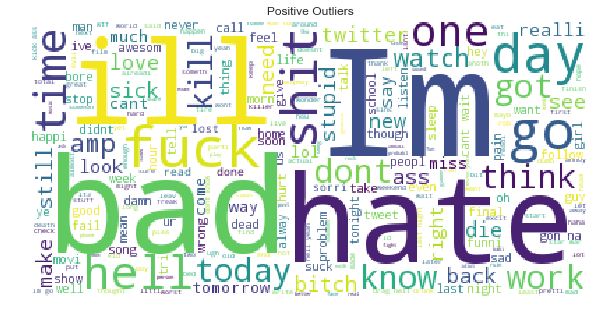

In [92]:
from wordcloud import WordCloud

def create_corpus(tweet_text):
    text = ""
    for row in tweet_text:
        text += row + " "

    # remove the weird characters and hyperlinks from text
    t1 = re.sub('https://t.co/[A-z0-9]+', '', text)
    announce_corpus = re.sub('\n|\xe2|\x80|\xa6', '', t1)
    return announce_corpus

po_corpus = create_corpus(pos_outliers)
wc = WordCloud(max_words=1000, background_color="white").generate(po_corpus)
plt.figure(figsize=(10, 6))
plt.axis("off")
plt.imshow(wc)
plt.title('Positive Outliers')
# plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3))

In [84]:
# negative outlier most common words

neg_outliers = master.loc[(master.sentiment=='negative') & 
                          (master.compound_score>0.5)]['cleaned_tweets']

no_tweets = ' '.join(neg_outliers).split()
freq_no_tweets = nltk.FreqDist(no_tweets)

print('The top 50 most common words are:')
print(freq_no_tweets.most_common(50))

The top 50 most common words are:
[(u'I', 22883), (u'love', 7724), (u'like', 5803), (u'good', 5123), (u'hope', 4569), (u'go', 4501), (u'wish', 4327), (u'get', 4237), (u'Im', 4114), (u'lol', 4076), (u'day', 3498), (u'fun', 3201), (u'work', 3143), (u'well', 3048), (u'great', 2936), (u'miss', 2701), (u'im', 2693), (u'feel', 2668), (u'dont', 2592), (u'want', 2565), (u'better', 2533), (u'got', 2515), (u'friend', 2475), (u'time', 2363), (u'cant', 2309), (u'today', 2294), (u'one', 2132), (u'u', 2105), (u'haha', 2105), (u'best', 2014), (u'realli', 2004), (u'back', 1938), (u'know', 1883), (u'see', 1842), (u'still', 1814), (u'would', 1759), (u'much', 1751), (u'thank', 1751), (u'could', 1645), (u'make', 1629), (u'need', 1616), (u'look', 1612), (u'home', 1588), (u'though', 1584), (u'night', 1556), (u'2', 1554), (u'last', 1542), (u'na', 1531), (u'amp', 1514), (u'think', 1496)]


In [95]:
master.loc[(master.sentiment=='negative') & (master.compound_score>0.5) &
          (master.cleaned_tweets.str.contains('good'))]['cleaned_tweets'].sample(10).values

array([u'it 3 day I tweet but that good caus I build new site So bit busi',
       u'off work doin good weather outsid oh joy catch ya later',
       u'had fun day friendshelp recept sai went well then went town aubrey still feel good',
       u'good luck flood noth wors deal water',
       u'man It feel good home now catch bill well I enjoy',
       u'I clean like entir first floor hous it lookin good yup now time fix herr lookin like cat lick',
       u'readi get next gen funder retreat start good woke earli not good cold water shower shave move',
       u'got back home late last night good sleep bed miss disney thank good vb distract',
       u'I lost pleas help find good home',
       'well done tournament hope good weather next film project still cant get arc UK'], dtype=object)

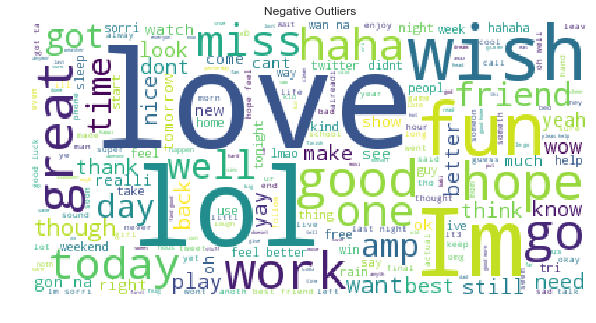

In [93]:
from wordcloud import WordCloud

no_corpus = create_corpus(neg_outliers)
wc = WordCloud(max_words=1000, background_color="white").generate(no_corpus)
plt.figure(figsize=(10, 6))
plt.axis("off")
plt.imshow(wc)
plt.title('Negative Outliers')
# plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3))

So what are we seeing? In the positive outliers, we see that fuck and shit and other swear words make up some of the most common words, which is why the compound score is potentially skewed. The classification model and NLTK will disagree in these instances, so many we approach this problem a different way?

- Have a list of obscene words and flag it any time you see it in a tweet. If you see a certain word, then respond a certain way.

For the negative outliers, some of the most common words are love, like, good, hope, which NLTK vader will score as super positive. So what do we do in these instances?

Maybe if we encounter scenarios where the tweet is classified as negative, but NLTK measures it as positive, then we leave it alone.

# Let's use some real data!!!

In [6]:
# We've been continuously adding data to the file NYCTtweets_feb_forward.json for a while
# now, so let's use that.

tweets = []
for line in open('./data/NYCTtweets_feb_forward.json', 'r'):
    tweets.append(line)
    
print("The number of tweets is {}".format(len(tweets)))

def transform_json_to_df(tweets):
    dt = []
    tweet_id = []
    tweet_text = []
    screen_name = []
    number_of_followers = []
    in_reply_to = []

    for counter, tweet in enumerate(tweets):
        # print(counter)
        if counter % 2 == 0:
            if json.loads(tweet).get('delete') == None:
                dt.append(json.loads(tweet).get('created_at'))
                tweet_id.append(json.loads(tweet).get('id_str'))
                tweet_text.append(json.loads(tweet).get('text'))
                screen_name.append(json.loads(tweet)['user'].get('screen_name'))
                in_reply_to.append(json.loads(tweet).get('in_reply_to_screen_name'))
        else:
            continue

    df = pd.DataFrame({'dt': dt,
                      'tweet_id': tweet_id,
                      'tweet_text': tweet_text,
                      'screen_name': screen_name,
                      'in_reply_to': in_reply_to})
    
    return df

eval_df = transform_json_to_df(tweets)
# convert the tweet_text from unicode to str
eval_df['tweet_text'] = eval_df.tweet_text.apply(lambda x: x.encode('utf-8'))
print(eval_df.shape)
eval_df.head()

FileNotFoundError: [Errno 2] No such file or directory: './data/NYCTtweets_feb_forward.json'

In [5]:
eval_df.info()

NameError: name 'eval_df' is not defined

In [32]:
# lets check out some of the more replies to NYCTSubway account
eval_df.loc[(eval_df.in_reply_to=='NYCTSubway')]['tweet_text'].tail(20).values

# eval_df.iloc[-20:]['tweet_text'].values

array([ '@NYCTSubway @SarahMeyerNYC It\xe2\x80\x99s been out for days. Should never be that long. Also, the escalator from the LIRR to\xe2\x80\xa6 https://t.co/WDHdbklagj',
       "@NYCTSubway I'm glad I got it fix!! I consider my self from now on enforcer activist of subway shenanigans",
       '@NYCTSubway Where is the Fourth R179 A train . I am at Beach 60 St waiting go to Manhattan 14 St 8 Ave from Clinton',
       '@NYCTSubway Where is the Fourth R179 A train is now from CLINTON',
       '@NYCTSubway I am in Far Rockaway right now.  I waiting on the R179 A train to go to 14 St from Clinton',
       '@NYCTSubway can I please get someone to call me back re: easypay metro? I\xe2\x80\x99ve been on hold for the past half day. Thanks',
       '@NYCTSubway Transit why your people coming here early in the morning so late at night making noise and people could\xe2\x80\xa6 https://t.co/nZcBIV3wJt',
       '@NYCTSubway Give me your Cell phone number so I can contact you so I can get it back 

### Let's clean this up and apply our model and see what's up

In [33]:
# clean tweet with function i found online
def clean_tweet(tweet): 
    ''' 
    Utility function to clean tweet text by removing links, special characters 
    using simple regex statements. 
    '''
    x = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) | (\w+:\/\/\S+)", " ", tweet).split())
    cleaned = re.sub(r'[^\x00-\x7f]',r'', re.sub(r'https:\/\/t.co\/[A-z0-9]*', '', x))
    #take out the hashtags
    without_hashtags = re.sub(r'[^\x00-\x7f]',r'', re.sub(r'\#[A-z0-9]*', '', cleaned))
    # or you can remove it by applying: .decode('utf8').encode('ascii', errors='ignore')
    return without_hashtags

# tokenize and shit
def tokenize_and_stem(row):
    
    # remove punctuations
    i = re.sub(r'[^\w\s]','',row)    
    # tokenize the words in the short reviews first
    words = word_tokenize(i)
    # remove stop words
    filtered = [ps.stem(w) for w in words if not w in stop_words]
    return ' '.join(filtered)


eval_df['cleaned'] = eval_df['tweet_text'].apply(lambda x: clean_tweet(x))
# remove neutral
eval_df['eval_text'] = eval_df['cleaned'].apply(lambda x: tokenize_and_stem(x))

eval_df.sample(10)

,dt,in_reply_to,screen_name,tweet_id,tweet_text,cleaned,eval_text
3637,Mon Feb 25 22:21:04 +0000 2019,None,KelKass,1100158764555096064,RT @NYCTSubway: Our crews are in the process o...,RT Our crews are in the process of cutting awa...,RT our crew process cut away remov fallen tree...
48921,Fri May 10 21:48:52 +0000 2019,MadelynOBoyle,NYCTSubway,1126967365030371330,@MadelynOBoyle Good Evening. There are residua...,Good Evening There are residual delays followi...,good even there residu delay follow earlier in...
16495,Tue Mar 19 01:19:42 +0000 2019,NYCTSubway,landelipipi,1107813867613237248,@NYCTSubway what's the status of the Jam bound...,what's the status of the Jam bound J At Chambe...,what statu jam bound J At chamber street
18397,Thu Mar 21 04:29:04 +0000 2019,akacuji,NYCTSubway,1108586297566920704,@akacuji We are seeing another bus approaching...,We are seeing another bus approaching Kew Gard...,We see anoth bu approach kew garden shortli RT
76144,Sun Jun 16 05:39:05 +0000 2019,BigBlakD,NYCTSubway,1140131661633478656,"@BigBlakD Thank you. During late nights, 2 tra...",Thank you During late nights 2 trains make all...,thank dure late night 2 train make stop 96 St ...
48221,Fri May 10 11:59:25 +0000 2019,kskovan,NYCTSubway,1126819026641010688,@kskovan Sorry for the delays we're showing a ...,Sorry for the delays we're showing a northboun...,sorri delay show northbound R train went area ...
14499,Mon Mar 11 22:50:21 +0000 2019,sanspoint,sanspoint,1105239564833169410,@NYCTSubway Why even report shit? Why even bot...,Why even report shit Why even bother communica...,whi even report shit whi even bother commun mt...
1876,Sat Feb 23 14:32:50 +0000 2019,NYCTSubway,IronCapHulkThor,1099316157838966784,@NYCTSubway Homeless yet again,Homeless yet again,homeless yet
64105,Wed May 29 22:18:43 +0000 2019,6trainisamess,6trainisamess,1133860247704092673,@NYCTSubway And here arrives a second parkches...,And here arrives a second parkchester ending t...,and arriv second parkchest end train get pelha...
41185,Mon Apr 29 14:15:30 +0000 2019,NYCTSubway,Dave57643578,1122867004807868418,@NYCTSubway Ok thanks. What is the eta for tan...,Ok thanks What is the eta for tangible signal ...,Ok thank what eta tangibl signal improv Is decad


In [34]:
eval_df.loc[(eval_df.in_reply_to=='NYCTSubway')][['tweet_text','eval_text']].tail(20).values

array([[ '@NYCTSubway @SarahMeyerNYC It\xe2\x80\x99s been out for days. Should never be that long. Also, the escalator from the LIRR to\xe2\x80\xa6 https://t.co/WDHdbklagj',
        u'it day should never long also escal lirr'],
       [ "@NYCTSubway I'm glad I got it fix!! I consider my self from now on enforcer activist of subway shenanigans",
        u'Im glad I got fix I consid self enforc activist subway shenanigan'],
       [ '@NYCTSubway Where is the Fourth R179 A train . I am at Beach 60 St waiting go to Manhattan 14 St 8 Ave from Clinton',
        u'where fourth r179 A train I beach 60 St wait go manhattan 14 St 8 ave clinton'],
       ['@NYCTSubway Where is the Fourth R179 A train is now from CLINTON',
        'where fourth r179 A train clinton'],
       [ '@NYCTSubway I am in Far Rockaway right now.  I waiting on the R179 A train to go to 14 St from Clinton',
        u'I far rockaway right I wait r179 A train go 14 St clinton'],
       [ '@NYCTSubway can I please get someone 

In [35]:
# column to predict

save_classifier = open("master_naive_bayes_june22.pickle", "wb")
pickle.dump(clf, save_classifier)
save_classifier.close()

#Loading the saved model with joblib
classifier_f = open("master_naive_bayes_june22.pickle", "rb")
classifier = pickle.load(classifier_f)
classifier_f.close()


In [3]:
def sklearn_naive_bayes(train, cat, n_features):
    vect = TfidfVectorizer(ngram_range=(1, 2), max_features=n_features)
    X = vect.fit_transform(train)
    y = cat

    #Partitioning the data into test and training set
    SPLIT_PERC = 0.75
    split_size = int(len(y)*SPLIT_PERC)

    X_train = X[:split_size]
    X_test = X[split_size:]
    y_train = y[:split_size]
    y_test = y[split_size:]

    #Training the model
    clf = MultinomialNB()
    clf.fit(X_train, y_train)

    #Evaluating the results
    print("Accuracy on training set:")
    print(clf.score(X_train, y_train))
    print("Accuracy on testing set:")
    print(clf.score(X_test, y_test))
    y_pred = clf.predict(X_test)
    print("Classification Report:")
    print(metrics.classification_report(y_test, y_pred))

In [4]:
# # New data to predict

pred_col = eval_df.loc[(eval_df.in_reply_to=='NYCTSubway')][['eval_text']].tail(20)

predictions = []

# for i in pred_col:
#     x = vect.transform(i)
#     predictions.append(classifier.predict(x))

pred_col.apply(lambda x: predictions.append(classifier.predict(vect.transform(x))))
    
pred_col['predictions'] = predictions[0]

NameError: name 'eval_df' is not defined

In [70]:
pred_col.values

array([[u'it day should never long also escal lirr', 'positive'],
       [u'Im glad I got fix I consid self enforc activist subway shenanigan',
        'positive'],
       [ u'where fourth r179 A train I beach 60 St wait go manhattan 14 St 8 ave clinton',
        'negative'],
       ['where fourth r179 A train clinton', 'negative'],
       [u'I far rockaway right I wait r179 A train go 14 St clinton',
        'negative'],
       [ u'I pleas get someon call back easypay metro ive hold past half day thank',
        'negative'],
       [u'transit peopl come earli morn late night make nois peopl could',
        'negative'],
       [ 'give cell phone number I contact I get back far rockaway later today ok clinton',
        'negative'],
       ['', 'negative'],
       [u'entranc 103 there might 96 but I didnt seem', 'negative'],
       ['I know r179 A train mott ave where two r179 A train clinton',
        'negative'],
       [u'thi happen way often A hard work new yorker deal morn commut',


well.....we did it. we applied the model to new data.

I think we want to add neutral classification in the model. Many of the NYCTSubway tweets aren't positive or negative.